In [1]:
#Chap4

In [15]:
import pymc as pm
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np

figsize(12.5, 4)

std_height = 15
mean_height = 150

# 地域の数
n_counties = 5000
pop_generator = pm.rdiscrete_uniform
norm = pm.rnormal

# 人口は一様分布から取得
population = pop_generator(100, 1500, size=n_counties)
print(population.size)

5000


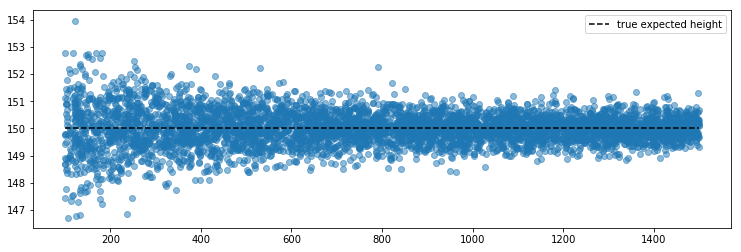

In [17]:
average_across_county = np.zeros(n_counties)
#地域ごとに正規分布からサンプリングして平均を取得
for i in range(n_counties):
    average_across_county[i] = norm(mean_height, 1./std_height**2, size=population[i]).mean()

# 平均の最大と最小を取得
i_min = np.argmin(average_across_county)
i_man = np.argmax(average_across_county)

plt.scatter(population, average_across_county, alpha=0.5)
plt.plot([100, 1500], [150, 150], color="k", ls="--", label="true expected height")
plt.legend()


In [22]:
# Kaggle
from os import makedirs
makedirs("data", exist_ok=True)
from urllib.request import urlretrieve

urlretrieve("https://git.io/vXtMv", "data/census_data.csv")

('data/census_data.csv', <http.client.HTTPMessage at 0x7f7e26411518>)

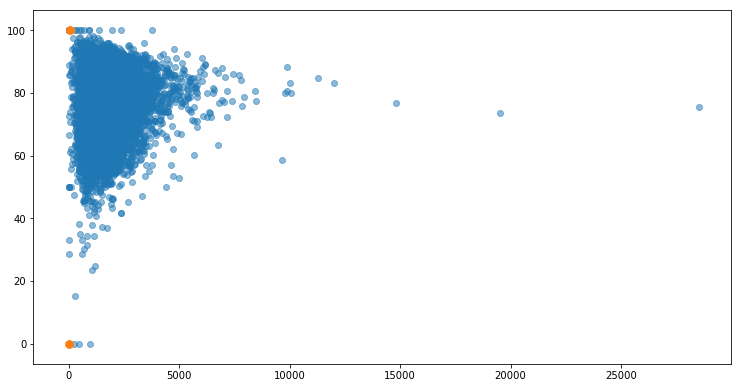

In [24]:
figsize(12.5, 6.5)
data = np.genfromtxt("data/census_data.csv", skip_header=1, delimiter=",")
plt.scatter(data[:, 1], data[:, 0], alpha=0.5)

i_min = np.argmin(data[:, 0])
i_max = np.argmax(data[:, 0])
plt.scatter([data[i_min, 1], data[i_max, 1]], [data[i_min, 0], data[i_max, 0]], s=60, marker="o", label="most extreme ponts")


In [27]:
# Reddit
from os import makedirs
makedirs("data", exist_ok=True)

from urllib.request import urlretrieve
urlretrieve("https://git.io/vXtX2", "top_showerthoughts_submissions.py")

import praw

In [29]:
%run top_showerthoughts_submissions.py 2
print("Title of submission: ", top_post)

Title of submission:  Monopoly would be more realistic if you had to start on a board already owned and fully developed by the winner of the previous game. And you have to pay to roll the dice.


In [ ]:
n_comments = len(contents)
comments = np.random.randint(n_comments, size=4)
